In [1]:
# To predict Energy Star Score of NYC buildings based on energy, fuel 
# and water consumptions.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# import the input data into a dataframe leaving out the unnecessary columns
data = pd.read_csv('/Users/babu/Mirror/Python_Programs/Scikit/Data/NYC/nyc_rawdata.csv', header=0,
            usecols=[0,1,3,13,14,15,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,49,50,52,53])


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Order                                           11746 non-null  int64  
 1   Property Id                                     11746 non-null  int64  
 2   Parent Property Id                              11746 non-null  object 
 3   Borough                                         11628 non-null  object 
 4   DOF Gross Floor Area                            11628 non-null  float64
 5   Primary Property Type - Self Selected           11746 non-null  object 
 6   Year Built                                      11746 non-null  int64  
 7   Number of Buildings - Self-reported             11746 non-null  int64  
 8   Occupancy                                       11746 non-null  int64  
 9   Metered Areas (Energy)                 

In [5]:
# Restrict the focus to standalone properties as data for campus properties are of poor quality
data1 = data[data['Parent Property Id'] == 'Not Applicable: Standalone Property']

In [6]:
# drop the 'Parent Property Id' column since all rows have the same value
data1 = data1.drop(columns=['Parent Property Id'])

In [7]:
data1.shape

(11324, 34)

In [8]:
data1 = data1.replace({'Not Available': np.nan})

In [9]:
# remove the records not having target value
data2 = data1.dropna(axis=0, subset=['ENERGY STAR Score'])

In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9406 entries, 422 to 11745
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Order                                           9406 non-null   int64  
 1   Property Id                                     9406 non-null   int64  
 2   Borough                                         9391 non-null   object 
 3   DOF Gross Floor Area                            9391 non-null   float64
 4   Primary Property Type - Self Selected           9406 non-null   object 
 5   Year Built                                      9406 non-null   int64  
 6   Number of Buildings - Self-reported             9406 non-null   int64  
 7   Occupancy                                       9406 non-null   int64  
 8   Metered Areas (Energy)                          9403 non-null   object 
 9   Metered Areas  (Water)                

In [11]:
# identify columns having >25% null values
col_to_be_removed = []
for col in data2.columns:
#    print(col, data2[col].isna().sum())
    if data2[col].isna().sum()/len(data2) > 0.25:
        col_to_be_removed.append(col)

In [12]:
col_to_be_removed

['Metered Areas  (Water)',
 'Fuel Oil #1 Use (kBtu)',
 'Fuel Oil #2 Use (kBtu)',
 'Fuel Oil #4 Use (kBtu)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'District Steam Use (kBtu)',
 'Water Intensity (All Water Sources) (gal/ft_)']

In [13]:
# drop those columns
data3 = data2.drop(columns=col_to_be_removed)

In [14]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9406 entries, 422 to 11745
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Order                                           9406 non-null   int64  
 1   Property Id                                     9406 non-null   int64  
 2   Borough                                         9391 non-null   object 
 3   DOF Gross Floor Area                            9391 non-null   float64
 4   Primary Property Type - Self Selected           9406 non-null   object 
 5   Year Built                                      9406 non-null   int64  
 6   Number of Buildings - Self-reported             9406 non-null   int64  
 7   Occupancy                                       9406 non-null   int64  
 8   Metered Areas (Energy)                          9403 non-null   object 
 9   ENERGY STAR Score                     

In [15]:
# Two GFA columns are available; examine the difference between those and eliminate one of them
diffGFA = (abs(data3['DOF Gross Floor Area'] - data3['Property GFA - Self-Reported (ft_)'])) / data3['DOF Gross Floor Area'] *100

In [16]:
diffGFA.describe()

count    9391.000000
mean        8.428241
std        19.390945
min         0.000000
25%         0.000000
50%         3.487693
75%        11.117052
max      1067.070437
dtype: float64

In [17]:
diffGFA.median()

3.487692949520234

In [18]:
# based on descriptive statistics on the difference between the two GFA columns, they are not very far apart.
# Hence we decide to drop the column 'Property GFA - Self-Reported (ft²)'

# Outlier Removal

In [19]:
# obtain the count of properties having GFA as NA / NaN
data3['DOF Gross Floor Area'].isna().sum()

15

In [20]:
# Fill null values of 'DOF Gross Floor Area' with values from 'Property GFA - Self-Reported (ft_)'
data3['DOF Gross Floor Area'].mask(cond=data3['DOF Gross Floor Area'].isna(), 
           other=data3['Property GFA - Self-Reported (ft_)'], axis=0, inplace=True)

In [21]:
# Verify if the NaNs have been dealt with
data3['DOF Gross Floor Area'].isna().sum()

0

In [22]:
data3.to_csv("Data/NYC/data3.csv")

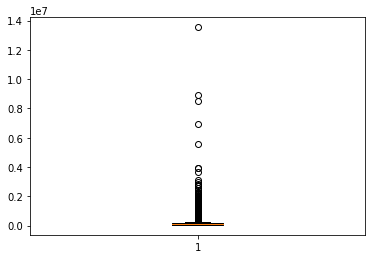

In [23]:
# box plot shows frequency is sparse when GFA > 0.3e7
plt.boxplot(data3['DOF Gross Floor Area'])
plt.show()

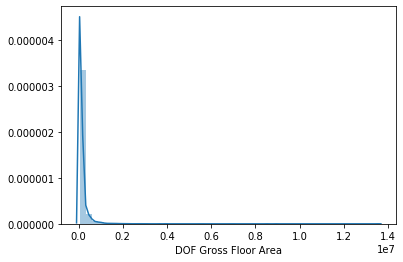

In [24]:
# distribution plot confirms the same as boxplot
ax = sns.distplot(data3['DOF Gross Floor Area'])

In [25]:
# find out the no. of records having GFA >0.3e7 (outliers)
data3[data3['DOF Gross Floor Area'] > 0.3e7]

,Order,Property Id,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),ENERGY STAR Score,...,Weather Norm Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Norm Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft_),Source EUI (kBtu/ft_),Water Required?,DOF Benchmarking Submission Status
509,550,2481300,Manhattan,3678000.0,Office,1972,1,100,Whole Building,77,...,NaN,256865235.1,74506183.1,32950.5,0,32950.5,3636683,267.2,No,In Compliance
2252,2651,4157757,Manhattan,8942176.0,Multifamily Housing,1947,35,100,Whole Building,82,...,266785.8,166404374.5,47170641.7,38755.9,1399,37356.8,8942176,105.9,No,In Compliance
2253,2652,4157734,Manhattan,3122165.0,Multifamily Housing,1947,21,100,Whole Building,90,...,67577.8,46199678.1,13121048.6,11649.9,352.3,11297.5,3122165,89.4,No,In Compliance
6863,8277,2775816,Bronx,8512479.0,Multifamily Housing,1941,1,100,Whole Building,48,...,NaN,47879332.9,NaN,16873,12429.8,4443.2,2920848,134.4,No,In Compliance
6867,8281,3584061,Bronx,3911254.0,Multifamily Housing,1940,1,100,Whole Building,1,...,281235.8,57290935.7,NaN,6810.4,1493.8,5316.6,3312,63231.7,Yes,In Compliance
6870,8286,2740271,Bronx,3911254.0,Multifamily Housing,1940,1,100,Whole Building,99,...,4932.7,1546336.7,442826,417,26.2,390.8,131237,75.1,Yes,In Compliance
7136,8623,3334926,Bronx,5541031.0,Multifamily Housing,1969,1,100,Whole Building,100,...,1261779.9,7026457.1,2059336.5,9083,8430.9,652.1,5818083,30.6,Yes,In Compliance
7141,8630,3334927,Bronx,13540113.0,Multifamily Housing,1969,1,100,Whole Building,100,...,3083296.3,17169913.6,5032213.2,22195.2,20601.9,1593.4,14217119,30.6,No,In Compliance
11481,14519,4335594,Queens,6940450.0,Multifamily Housing,1962,28,100,Whole Building,10,...,10483444.3,NaN,NaN,63451.1,63451.1,0,6940450,173.8,Yes,In Compliance


In [26]:
# remove the outliers based on GFA > 0.3e7
data4 = data3[data3['DOF Gross Floor Area'] < 0.3e7]

In [27]:
data4.shape

(9397, 26)

In [28]:
data4.to_csv("Data/NYC/data4.csv")

In [29]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9397 entries, 422 to 11745
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Order                                           9397 non-null   int64  
 1   Property Id                                     9397 non-null   int64  
 2   Borough                                         9382 non-null   object 
 3   DOF Gross Floor Area                            9397 non-null   float64
 4   Primary Property Type - Self Selected           9397 non-null   object 
 5   Year Built                                      9397 non-null   int64  
 6   Number of Buildings - Self-reported             9397 non-null   int64  
 7   Occupancy                                       9397 non-null   int64  
 8   Metered Areas (Energy)                          9394 non-null   object 
 9   ENERGY STAR Score                     

In [30]:
# Assign correct dtypes to each column
data5 = data4.astype({'ENERGY STAR Score':'float64', 'Site EUI (kBtu/ft_)':'float64',
        'Weather Norm. Site EUI (kBtu/ft_)':'float64', 'Weather Norm Site Elect Int (kWh/ft_)':'float64',
        'Weather Norm Site Natural Gas Int (therms/ft_)':'float64',
        'Weather Norm Source EUI (kBtu/ft_)':'float64', 'Natural Gas Use (kBtu)':'float64',
        'Weather Norm Site Natural Gas Use (therms)':'float64',
        'Electricity Use - Grid Purchase (kBtu)':'float64',
        'Weather Norm Site Electricity (kWh)':'float64', 'Total GHG Emissions (Metric Tons CO2e)':'float64',
        'Direct GHG Emissions (Metric Tons CO2e)':'float64', 
        'Indirect GHG Emissions (Metric Tons CO2e)':'float64', 'Source EUI (kBtu/ft_)':'float64' })

In [31]:
# Normalize the non-normalized columns by dividing by GFA
data5['Natural Gas Use (kBtu)_Norm'] = data5['Natural Gas Use (kBtu)']/data5['DOF Gross Floor Area']
data5['Weather Norm Site Natural Gas Use (therms)_Norm'] = data5['Weather Norm Site Natural Gas Use (therms)']/data5['DOF Gross Floor Area']
data5['Electricity Use - Grid Purchase (kBtu)_Norm'] = data5['Electricity Use - Grid Purchase (kBtu)']/data5['DOF Gross Floor Area']
data5['Weather Norm Site Electricity (kWh)_Norm'] = data5['Weather Norm Site Electricity (kWh)']/data5['DOF Gross Floor Area']
data5['Total GHG Emissions (Metric Tons CO2e)_Norm'] = data5['Total GHG Emissions (Metric Tons CO2e)']/data5['DOF Gross Floor Area']
data5['Direct GHG Emissions (Metric Tons CO2e)_Norm'] = data5['Direct GHG Emissions (Metric Tons CO2e)']/data5['DOF Gross Floor Area']
data5['Indirect GHG Emissions (Metric Tons CO2e)_Norm'] = data5['Indirect GHG Emissions (Metric Tons CO2e)']/data5['DOF Gross Floor Area']

In [32]:
# calculate the building age and use it instead of Year Built
data5['Age'] = datetime.now().year - data5['Year Built']

In [33]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9397 entries, 422 to 11745
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Order                                            9397 non-null   int64  
 1   Property Id                                      9397 non-null   int64  
 2   Borough                                          9382 non-null   object 
 3   DOF Gross Floor Area                             9397 non-null   float64
 4   Primary Property Type - Self Selected            9397 non-null   object 
 5   Year Built                                       9397 non-null   int64  
 6   Number of Buildings - Self-reported              9397 non-null   int64  
 7   Occupancy                                        9397 non-null   int64  
 8   Metered Areas (Energy)                           9394 non-null   object 
 9   ENERGY STAR Score          

In [34]:
data5.to_csv('Data/NYC/data5.csv')

In [35]:
len(data5)

9397

In [36]:
#Identify all columns having numeric values
numeric_cols = ['Age', 'Number of Buildings - Self-reported', 'Occupancy', 
        'Site EUI (kBtu/ft_)', 'Weather Norm. Site EUI (kBtu/ft_)', 'Weather Norm Site Elect Int (kWh/ft_)',
        'Weather Norm Site Natural Gas Int (therms/ft_)', 'Weather Norm Source EUI (kBtu/ft_)',
        'Natural Gas Use (kBtu)_Norm', 'Weather Norm Site Natural Gas Use (therms)_Norm',
        'Electricity Use - Grid Purchase (kBtu)_Norm', 'Weather Norm Site Electricity (kWh)_Norm',
        'Total GHG Emissions (Metric Tons CO2e)_Norm', 'Direct GHG Emissions (Metric Tons CO2e)_Norm',
        'Indirect GHG Emissions (Metric Tons CO2e)_Norm', 'Source EUI (kBtu/ft_)']

In [37]:
# function to detect the no. of outliers for each column
def outlier_detect(df):
    outlier = pd.DataFrame()
    for col in df.columns:
        first_quartile = df[col].quantile(q=0.25)
        third_quartile = df[col].quantile(q=0.75)
        inter_quartile = third_quartile - first_quartile
        lower_limit = first_quartile - 5* inter_quartile
        upper_limit = third_quartile + 5* inter_quartile
        outlier.at['lower_limit', col] = lower_limit
        outlier.at['upper_limit', col] = upper_limit
        no_of_outliers = len(df[(df[col] < lower_limit) | (df[col] > upper_limit)])
        outlier.at['#outliers', col] = no_of_outliers
    return outlier

In [38]:
# call the function to get the lower limit, upper limit and estimated no. of outliers for each column
outlier_data = outlier_detect(data5[numeric_cols])

In [39]:
outlier_data

,Age,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft_),Weather Norm. Site EUI (kBtu/ft_),Weather Norm Site Elect Int (kWh/ft_),Weather Norm Site Natural Gas Int (therms/ft_),Weather Norm Source EUI (kBtu/ft_),Natural Gas Use (kBtu)_Norm,Weather Norm Site Natural Gas Use (therms)_Norm,Electricity Use - Grid Purchase (kBtu)_Norm,Weather Norm Site Electricity (kWh)_Norm,Total GHG Emissions (Metric Tons CO2e)_Norm,Direct GHG Emissions (Metric Tons CO2e)_Norm,Indirect GHG Emissions (Metric Tons CO2e)_Norm,Source EUI (kBtu/ft_)
lower_limit,-135.0,1.0,100.0,-105.1,-109.7,-20.7,-2.9,-197.0,-285.333423,-3.074530,-66.074167,-19.440087,-0.007904,-0.011136,-0.007333,-195.5
upper_limit,283.0,1.0,100.0,265.6,278.6,33.2,3.7,466.3,365.528529,3.928211,109.402873,31.944423,0.019100,0.017258,0.011593,455.7
#outliers,2.0,286.0,693.0,97.0,69.0,90.0,16.0,103.0,17.000000,12.000000,103.000000,99.000000,97.000000,29.000000,123.000000,127.0


In [40]:
# prepare a list of columns for which outliers need to be removed (some columns have been skipped from numeric_cols)
outlier_cols = ['Site EUI (kBtu/ft_)', 'Weather Norm. Site EUI (kBtu/ft_)', 'Weather Norm Site Elect Int (kWh/ft_)',
        'Weather Norm Site Natural Gas Int (therms/ft_)', 'Weather Norm Source EUI (kBtu/ft_)',
        'Natural Gas Use (kBtu)_Norm', 'Weather Norm Site Natural Gas Use (therms)_Norm',
        'Electricity Use - Grid Purchase (kBtu)_Norm', 'Weather Norm Site Electricity (kWh)_Norm',
        'Total GHG Emissions (Metric Tons CO2e)_Norm', 'Direct GHG Emissions (Metric Tons CO2e)_Norm',
        'Indirect GHG Emissions (Metric Tons CO2e)_Norm', 'Source EUI (kBtu/ft_)']

In [41]:
# remove the outliers for each column
for col in outlier_cols:
    data5.drop(index = data5[(data5[col] < outlier_data.at['lower_limit', col])
                | (data5[col] > outlier_data.at['upper_limit', col])].index, inplace=True)


In [42]:
# row count after outliers have been removed
len(data5)

9188

In [43]:
#Remove the columns which have been converted into normalized counterparts
cols_to_be_dropped = ['Year Built', 'Natural Gas Use (kBtu)', 'Weather Norm Site Natural Gas Use (therms)',
    'Electricity Use - Grid Purchase (kBtu)', 'Weather Norm Site Electricity (kWh)', 
    'Total GHG Emissions (Metric Tons CO2e)', 'Direct GHG Emissions (Metric Tons CO2e)',
    'Indirect GHG Emissions (Metric Tons CO2e)', 'DOF Benchmarking Submission Status']

In [44]:
data6 = data5.drop(columns=cols_to_be_dropped)

In [45]:
# Remove the columns whose variance is low (VARIANCE THRESHOLD METHOD)
data6.drop(columns='Metered Areas (Energy)', inplace=True)

In [46]:
# Remove redundant columns
data6.drop(columns=['Direct GHG Emissions (Metric Tons CO2e)_Norm', 
            'Indirect GHG Emissions (Metric Tons CO2e)_Norm'], inplace=True)

In [47]:
data6.shape

(9188, 22)

In [48]:
data6.to_csv('Data/NYC/data6.csv')

In [49]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9188 entries, 422 to 11745
Data columns (total 22 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Order                                            9188 non-null   int64  
 1   Property Id                                      9188 non-null   int64  
 2   Borough                                          9182 non-null   object 
 3   DOF Gross Floor Area                             9188 non-null   float64
 4   Primary Property Type - Self Selected            9188 non-null   object 
 5   Number of Buildings - Self-reported              9188 non-null   int64  
 6   Occupancy                                        9188 non-null   int64  
 7   ENERGY STAR Score                                9188 non-null   float64
 8   Site EUI (kBtu/ft_)                              9188 non-null   float64
 9   Weather Norm. Site EUI (kBt

# Exploratory Data Analysis

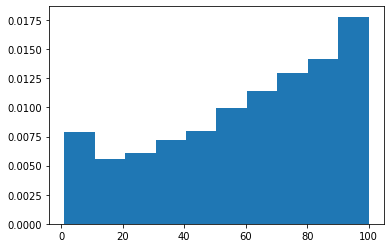

In [192]:
# study the distribution of the target variable
plt.hist(data6['ENERGY STAR Score'], bins=10, density=True)
plt.show()

In [50]:
# calculate the correlation coeff. between numeric features and target

In [51]:
# extract numeric features only for calculating correlation coefficient
data_numeric = data6.select_dtypes(include='number')

In [52]:
# drop columns irrelevant for correlation calculation
data_numeric1 = data_numeric.drop(columns=['Order', 'Property Id', 'DOF Gross Floor Area'])

In [53]:
data_numeric1.shape

(9188, 16)

In [54]:
data_numeric1.columns

Index(['Number of Buildings - Self-reported', 'Occupancy', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft_)', 'Weather Norm. Site EUI (kBtu/ft_)',
       'Weather Norm Site Elect Int (kWh/ft_)',
       'Weather Norm Site Natural Gas Int (therms/ft_)',
       'Weather Norm Source EUI (kBtu/ft_)',
       'Property GFA - Self-Reported (ft_)', 'Source EUI (kBtu/ft_)',
       'Natural Gas Use (kBtu)_Norm',
       'Weather Norm Site Natural Gas Use (therms)_Norm',
       'Electricity Use - Grid Purchase (kBtu)_Norm',
       'Weather Norm Site Electricity (kWh)_Norm',
       'Total GHG Emissions (Metric Tons CO2e)_Norm', 'Age'],
      dtype='object')

In [55]:
#calculate the pearson correlation coefficient between features and target
data_numeric1.corr(method='pearson')['ENERGY STAR Score'].sort_values()

Site EUI (kBtu/ft_)                               -0.716174
Weather Norm. Site EUI (kBtu/ft_)                 -0.706193
Weather Norm Source EUI (kBtu/ft_)                -0.661553
Source EUI (kBtu/ft_)                             -0.655616
Total GHG Emissions (Metric Tons CO2e)_Norm       -0.619936
Weather Norm Site Elect Int (kWh/ft_)             -0.359166
Weather Norm Site Natural Gas Int (therms/ft_)    -0.344304
Natural Gas Use (kBtu)_Norm                       -0.317073
Electricity Use - Grid Purchase (kBtu)_Norm       -0.309235
Weather Norm Site Electricity (kWh)_Norm          -0.306300
Weather Norm Site Natural Gas Use (therms)_Norm   -0.302900
Occupancy                                         -0.033155
Number of Buildings - Self-reported               -0.021783
Property GFA - Self-Reported (ft_)                 0.022239
Age                                                0.126342
ENERGY STAR Score                                  1.000000
Name: ENERGY STAR Score, dtype: float64

In [56]:
#calculate the pearson correlation coefficient between features and target
correlation = data_numeric1.corr(method='spearman')['ENERGY STAR Score'].sort_values()

In [57]:
print(correlation)

Site EUI (kBtu/ft_)                               -0.756553
Source EUI (kBtu/ft_)                             -0.751454
Weather Norm Source EUI (kBtu/ft_)                -0.749245
Weather Norm. Site EUI (kBtu/ft_)                 -0.741055
Total GHG Emissions (Metric Tons CO2e)_Norm       -0.662478
Weather Norm Site Elect Int (kWh/ft_)             -0.447751
Electricity Use - Grid Purchase (kBtu)_Norm       -0.411832
Weather Norm Site Electricity (kWh)_Norm          -0.408980
Weather Norm Site Natural Gas Int (therms/ft_)    -0.342746
Natural Gas Use (kBtu)_Norm                       -0.315687
Weather Norm Site Natural Gas Use (therms)_Norm   -0.305477
Occupancy                                         -0.016298
Number of Buildings - Self-reported               -0.007420
Property GFA - Self-Reported (ft_)                 0.039660
Age                                                0.120011
ENERGY STAR Score                                  1.000000
Name: ENERGY STAR Score, dtype: float64


In [58]:
# Select features based on a threshold
threshold = 0.4
correlation = correlation[correlation.abs() >= threshold]

In [59]:
# List of numeric features selected for modeling
correlation

Site EUI (kBtu/ft_)                           -0.756553
Source EUI (kBtu/ft_)                         -0.751454
Weather Norm Source EUI (kBtu/ft_)            -0.749245
Weather Norm. Site EUI (kBtu/ft_)             -0.741055
Total GHG Emissions (Metric Tons CO2e)_Norm   -0.662478
Weather Norm Site Elect Int (kWh/ft_)         -0.447751
Electricity Use - Grid Purchase (kBtu)_Norm   -0.411832
Weather Norm Site Electricity (kWh)_Norm      -0.408980
ENERGY STAR Score                              1.000000
Name: ENERGY STAR Score, dtype: float64

In [60]:
# select only those columns having correlation > threshold
data_numeric2 = data_numeric1[correlation.index]

In [61]:
data_numeric2

,Site EUI (kBtu/ft_),Source EUI (kBtu/ft_),Weather Norm Source EUI (kBtu/ft_),Weather Norm. Site EUI (kBtu/ft_),Total GHG Emissions (Metric Tons CO2e)_Norm,Weather Norm Site Elect Int (kWh/ft_),Electricity Use - Grid Purchase (kBtu)_Norm,Weather Norm Site Electricity (kWh)_Norm,ENERGY STAR Score
422,104.8,215.8,220.4,105.9,0.007599,14.5,45.744087,13.840992,84.0
423,69.1,189.3,191.1,70.6,0.006508,16.1,59.098354,17.320735,84.0
424,124.3,225.0,224.5,123.4,NaN,13.1,45.914081,13.456646,77.0
425,124.0,222.2,225.0,128.5,0.009774,13.0,45.309799,13.036381,1.0
426,67.3,175.7,177.2,69.5,0.005812,14.2,49.377255,14.300869,88.0
...,...,...,...,...,...,...,...,...,...
11741,109.3,153.4,160.8,117.7,0.007215,5.3,20.165868,5.697034,16.0
11742,44.3,103.6,101.0,43.9,0.003438,7.7,27.280647,7.711726,83.0
11743,70.0,92.7,96.9,74.9,0.004285,2.6,9.628526,2.686070,92.0
11744,95.0,149.4,151.4,99.6,0.005988,6.6,23.751490,6.568670,29.0


In [62]:
numeric_features = correlation.drop(index='ENERGY STAR Score').index

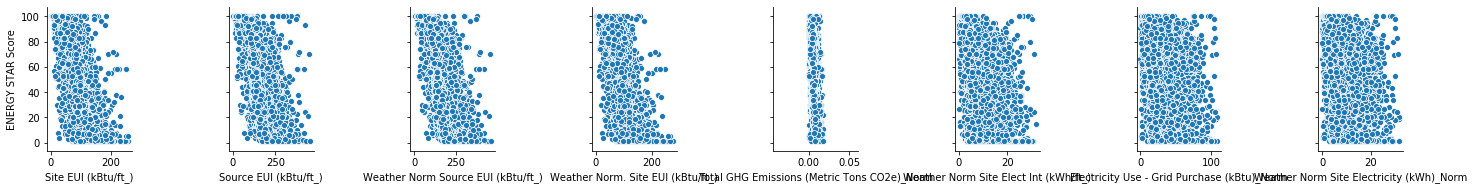

In [63]:
# study the relationships between each feature and target to determine if any transformation is needed
sns.pairplot(data=data_numeric2, x_vars = numeric_features, y_vars='ENERGY STAR Score')

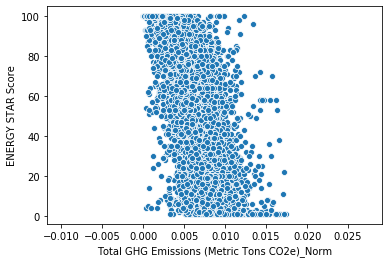

In [64]:
sns.scatterplot(x='Total GHG Emissions (Metric Tons CO2e)_Norm', y='ENERGY STAR Score', data=data_numeric2)

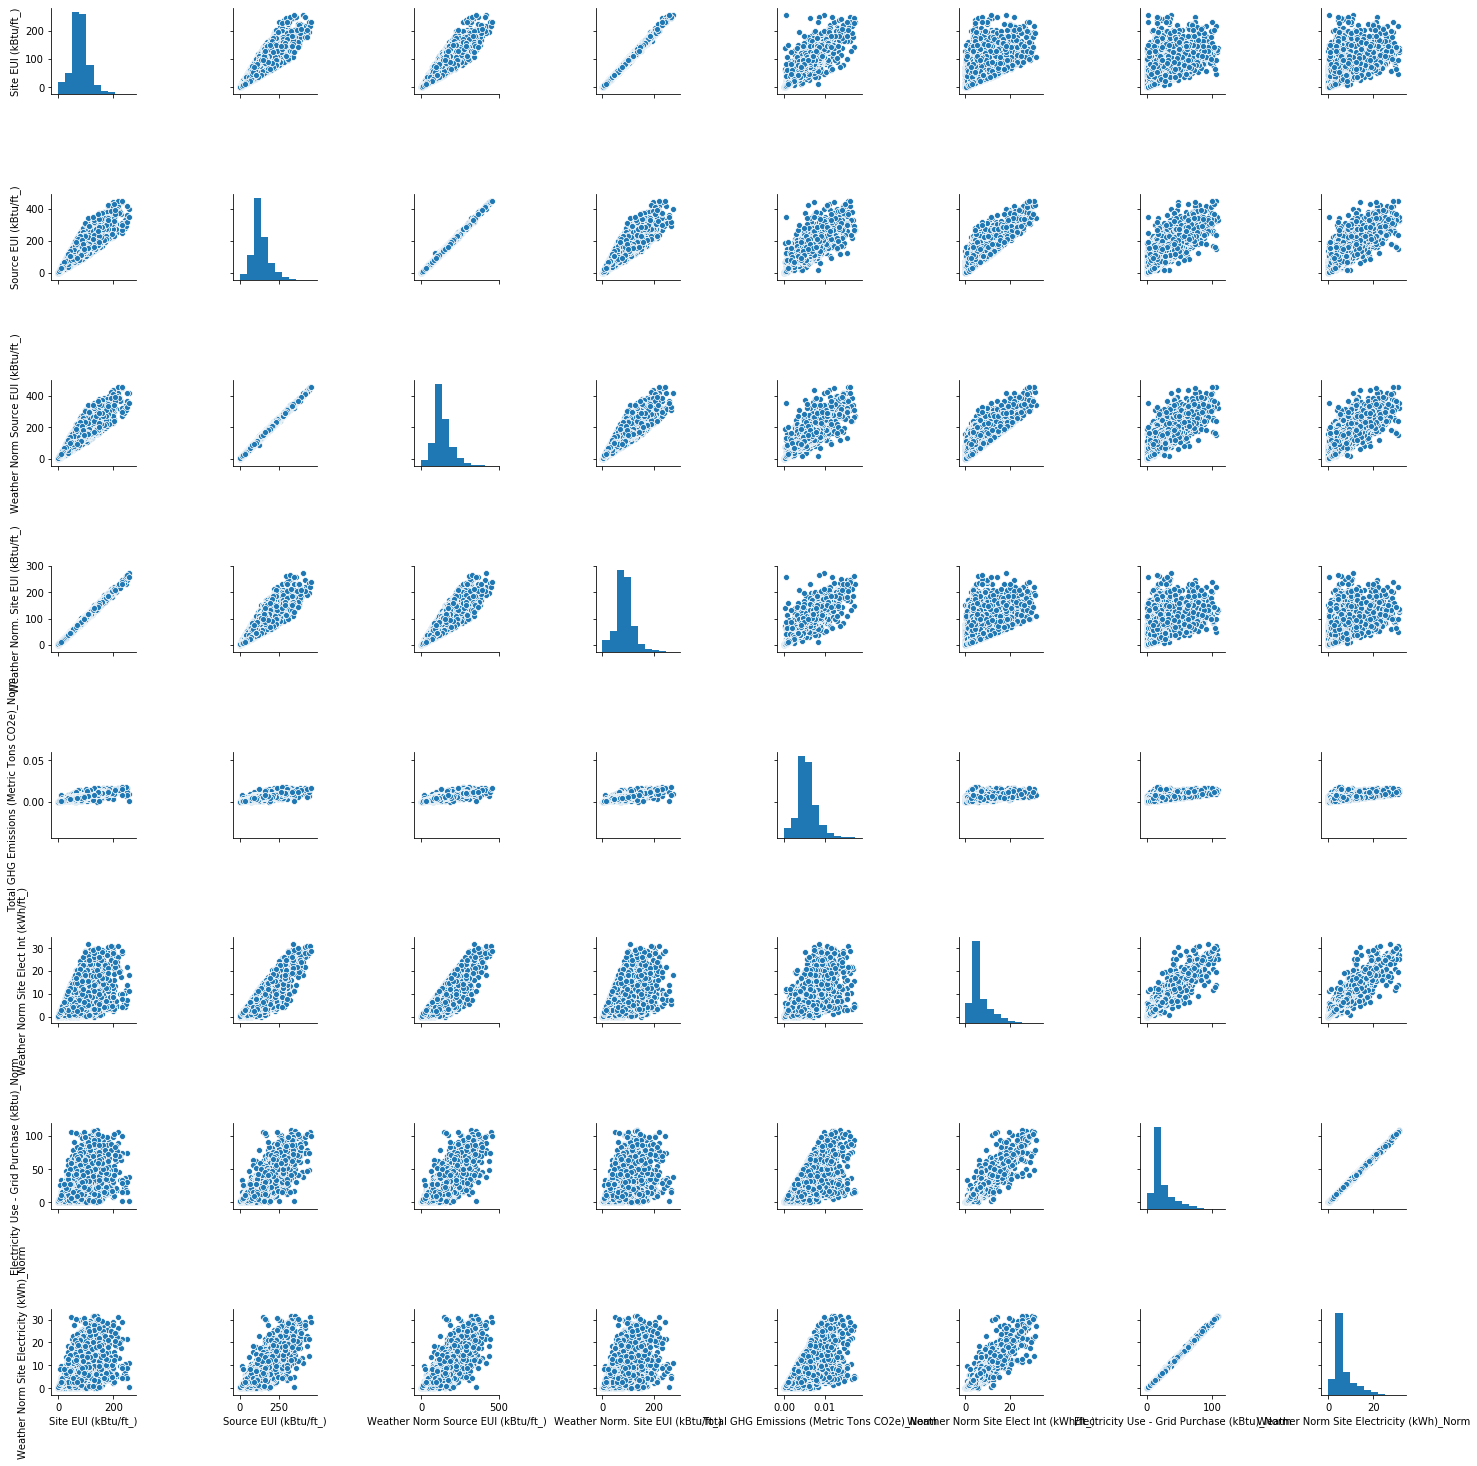

In [65]:
# study the relationship between features to check for collinearity
sns.pairplot(data = data_numeric2.drop(columns='ENERGY STAR Score'))

In [66]:
# dropping the features based on multi-collinearity analysis
data_numeric3 = data_numeric2.drop(columns=['Weather Norm. Site EUI (kBtu/ft_)', 'Weather Norm Source EUI (kBtu/ft_)',
                           'Weather Norm Site Electricity (kWh)_Norm'])

In [67]:
data_numeric3.shape

(9188, 6)

In [68]:
data_numeric3.columns

Index(['Site EUI (kBtu/ft_)', 'Source EUI (kBtu/ft_)',
       'Total GHG Emissions (Metric Tons CO2e)_Norm',
       'Weather Norm Site Elect Int (kWh/ft_)',
       'Electricity Use - Grid Purchase (kBtu)_Norm', 'ENERGY STAR Score'],
      dtype='object')

In [69]:
data_numeric3

,Site EUI (kBtu/ft_),Source EUI (kBtu/ft_),Total GHG Emissions (Metric Tons CO2e)_Norm,Weather Norm Site Elect Int (kWh/ft_),Electricity Use - Grid Purchase (kBtu)_Norm,ENERGY STAR Score
422,104.8,215.8,0.007599,14.5,45.744087,84.0
423,69.1,189.3,0.006508,16.1,59.098354,84.0
424,124.3,225.0,NaN,13.1,45.914081,77.0
425,124.0,222.2,0.009774,13.0,45.309799,1.0
426,67.3,175.7,0.005812,14.2,49.377255,88.0
...,...,...,...,...,...,...
11741,109.3,153.4,0.007215,5.3,20.165868,16.0
11742,44.3,103.6,0.003438,7.7,27.280647,83.0
11743,70.0,92.7,0.004285,2.6,9.628526,92.0
11744,95.0,149.4,0.005988,6.6,23.751490,29.0


In [70]:
# find out the number of NaN in each column so that we know how many need to be imputed
for col in data_numeric3.columns:
    print(col, data_numeric3[col].isna().sum())

Site EUI (kBtu/ft_) 0
Source EUI (kBtu/ft_) 0
Total GHG Emissions (Metric Tons CO2e)_Norm 2
Weather Norm Site Elect Int (kWh/ft_) 438
Electricity Use - Grid Purchase (kBtu)_Norm 39
ENERGY STAR Score 0


In [71]:
# Extract the feature columns
X_numeric = data_numeric3.drop(columns=['ENERGY STAR Score'])

In [72]:
X_numeric.shape

(9188, 5)

In [73]:
numeric_feature_list = list(X_numeric.columns)

In [74]:
numeric_feature_list

['Site EUI (kBtu/ft_)',
 'Source EUI (kBtu/ft_)',
 'Total GHG Emissions (Metric Tons CO2e)_Norm',
 'Weather Norm Site Elect Int (kWh/ft_)',
 'Electricity Use - Grid Purchase (kBtu)_Norm']

In [75]:
# Extract the target
y = data_numeric3['ENERGY STAR Score'].to_numpy(dtype='float64')

In [76]:
y.shape

(9188,)

In [77]:
type(y)

numpy.ndarray

In [78]:
# feature scaling
scaler1 = MinMaxScaler().fit(X_numeric)

In [79]:
X_numeric_scaled = scaler1.transform(X_numeric)

In [80]:
np.savetxt('Data/NYC/X_numeric_scaled.csv', X_numeric_scaled, fmt='%.8e', delimiter=',')

In [81]:
# impute missing values in the features
imputer = KNNImputer().fit(X_numeric_scaled)

In [82]:
X_imputed = imputer.transform(X_numeric_scaled)

In [83]:
# check if all the missing values have been imputed
np.isnan(X_imputed).sum()

0

In [84]:
np.savetxt('Data/NYC/X_imputed.csv', X_imputed, fmt='%.8e', delimiter=',')

In [85]:
X_imputed.shape

(9188, 5)

In [86]:
# determine correlation between categorical features and target

In [87]:
# impute missing values
imputer1 = SimpleImputer(strategy="most_frequent").fit(data6[['Borough', 'Primary Property Type - Self Selected']])

In [88]:
X_categorical = imputer1.transform(data6[['Borough', 'Primary Property Type - Self Selected']])

In [89]:
print(type(X_categorical)); print(X_categorical.shape);

<class 'numpy.ndarray'>
(9188, 2)


In [90]:
# check if all missing values have been imputed
pd.isnull(X_categorical).sum()

0

In [91]:
# One Hot Encoding of the categorical features 'Borough' and 'Primary Property Type - Self Selected'
ohe = OneHotEncoder(sparse=False).fit(X_categorical)

In [92]:
ohe.categories_

[array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
       dtype=object),
 array(['College/University', 'Courthouse', 'Distribution Center',
        'Financial Office', 'Hospital (General Medical & Surgical)',
        'Hotel', 'K-12 School', 'Manufacturing/Industrial Plant',
        'Medical Office', 'Mixed Use Property', 'Multifamily Housing',
        'Non-Refrigerated Warehouse', 'Office', 'Other',
        'Refrigerated Warehouse', 'Residence Hall/Dormitory',
        'Residential Care Facility', 'Retail Store',
        'Self-Storage Facility', 'Senior Care Community',
        'Supermarket/Grocery Store', 'Wholesale Club/Supercenter',
        'Worship Facility'], dtype=object)]

In [93]:
type(ohe.categories_)

list

In [94]:
# convert the ohe categories into a single list

In [95]:
cat_list1 = []; cat_list2 = [];

In [96]:
cat_list1 = [x for x in ohe.categories_[0]]

In [97]:
cat_list2 = [x for x in ohe.categories_[1]]

In [98]:
cat_list = cat_list1 + cat_list2

In [99]:
cat_list

['Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'College/University',
 'Courthouse',
 'Distribution Center',
 'Financial Office',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Mixed Use Property',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall/Dormitory',
 'Residential Care Facility',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Supermarket/Grocery Store',
 'Wholesale Club/Supercenter',
 'Worship Facility']

In [100]:
X_cat_encoded = ohe.transform(X_categorical)

In [101]:
print(type(X_cat_encoded)); print(X_cat_encoded.shape);

<class 'numpy.ndarray'>
(9188, 28)


In [102]:
# calculate the variance of each column in the encoded feature matrix
np.var(X_cat_encoded, axis=0)

array([1.46493676e-01, 1.64156357e-01, 2.43961147e-01, 1.47889564e-01,
       1.18288055e-02, 2.17627846e-04, 1.08825769e-04, 6.48761260e-03,
       1.19578044e-03, 1.30434560e-03, 2.06686752e-02, 8.20323835e-03,
       1.08825769e-04, 2.17201404e-03, 1.41288707e-03, 1.62811820e-01,
       1.55323998e-02, 1.03894340e-01, 3.25446736e-03, 9.78579033e-04,
       7.34618360e-03, 1.08825769e-04, 5.41226665e-03, 3.26406232e-04,
       9.16561256e-03, 5.43891931e-04, 3.26406232e-04, 1.08719158e-03])

In [103]:
# set variance threshold for eliminating features (VARIANCE THRESHOLD METHOD FOR FEATURE SELECTION)
threshold1 = 1e-02

In [104]:
index_to_retain = np.var(X_cat_encoded, axis=0) > threshold1

In [105]:
index_to_retain

array([ True,  True,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False])

In [106]:
X_cat_retained = X_cat_encoded[:, index_to_retain]

In [107]:
X_cat_retained.shape

(9188, 9)

In [108]:
# create a list index for the array index_to_retain

In [109]:
cat_index = []

In [110]:
cat_index = [i for i in index_to_retain]

In [111]:
cat_index

[True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [112]:
len(cat_index)

28

In [113]:
# Extract the list of categories selected

In [114]:
cat_list_retained = []

In [115]:
for i in range(len(cat_index)):
    if (cat_index[i] == True):
        cat_list_retained.append(cat_list[i])

In [116]:
cat_list_retained

['Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'Hotel',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office']

In [117]:
# combine the numeric and categorical feature lists
feature_list = numeric_feature_list + cat_list_retained

In [118]:
feature_list

['Site EUI (kBtu/ft_)',
 'Source EUI (kBtu/ft_)',
 'Total GHG Emissions (Metric Tons CO2e)_Norm',
 'Weather Norm Site Elect Int (kWh/ft_)',
 'Electricity Use - Grid Purchase (kBtu)_Norm',
 'Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'Hotel',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office']

In [119]:
# combine the numeric and categorical features to form the input array
X = np.hstack((X_imputed, X_cat_retained))

In [120]:
X.shape

(9188, 14)

In [121]:
# split the Feature and target arrays into train and test arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [122]:
print(X_train.shape); print(X_test.shape); print(y_train.shape); print(y_test.shape);

(6891, 14)
(2297, 14)
(6891,)
(2297,)


In [123]:
# Establish a baseline model based on median
baseline = np.median(y_train)

In [124]:
baseline

65.0

In [125]:
# convert baseline into an array of size y_test
baseline_predicted = np.full(y_test.shape, baseline)

In [126]:
baseline_predicted.shape

(2297,)

In [127]:
# calculate baseline performance
print('Baseline performance is %0.4f' %mean_absolute_error(y_test, baseline_predicted))

Baseline performance is 23.7327


# Model Selection

In [128]:
# Model 1: Fit a linear regression model
ridge = Ridge(random_state=1).fit(X_train, y_train)

In [129]:
y_predicted1 = ridge.predict(X_test)

In [130]:
y_predicted1.shape

(2297,)

In [131]:
# calculate Model1 performance
print('Ridge regression performance is %0.4f' %mean_absolute_error(y_test, y_predicted1))

Ridge regression performance is 13.6141


In [132]:
# Model 2: SVM Regressor
svr = SVR().fit(X_train, y_train)

In [133]:
y_predicted2 = svr.predict(X_test)

In [134]:
# calculate Model2 performance
print('SVR performance is %0.4f' %mean_absolute_error(y_test, y_predicted2))

SVR performance is 11.1409


In [135]:
# Model 3: Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=500, min_samples_split=15, min_samples_leaf=5, random_state=1, max_samples=0.5).fit(X_train, y_train)

In [136]:
y_predicted3 = random_forest.predict(X_test)

In [137]:
# calculate Model3 performance
print('Random Forest performance is %0.4f' %mean_absolute_error(y_test, y_predicted3))

Random Forest performance is 9.1739


In [138]:
# Model 4: K-NN Regressor
knn = KNeighborsRegressor().fit(X_train, y_train)

In [139]:
y_predicted4 = knn.predict(X_test)

In [140]:
y_predicted4.shape

(2297,)

In [141]:
# calculate Model4 performance
print('K-NN Regressor performance is %0.4f' %mean_absolute_error(y_test, y_predicted4))

K-NN Regressor performance is 9.5904


In [142]:
knn.effective_metric_

'euclidean'

In [143]:
# Model 5: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=1).fit(X_train, y_train)

In [144]:
y_predicted5 = gbr.predict(X_test)

In [145]:
y_predicted5.shape

(2297,)

In [146]:
# calculate Model5 performance
print('Gradient Boosting Regressor performance is %0.4f' %mean_absolute_error(y_test, y_predicted5))

Gradient Boosting Regressor performance is 9.3094


# Hyper-parameter tuning

In [147]:
# form the grid of hyper-parameters to be tuned
param_grid = {'loss':['ls','lad','huber'], 'learning_rate':[0.1,0.2,0.3,0.4,0.5], 
    'n_estimators':[100, 200, 300, 400, 500], 'max_depth':[2,3,4,5,10], 'max_features':["auto","sqrt","log2"],
             'min_samples_split': [2,4,6,8,10], 'min_samples_leaf':[1,2,4,6,8]}

In [148]:
# instantiate an estimator for fine tuning
gbr1 = GradientBoostingRegressor(random_state=2)

In [149]:
rscv = RandomizedSearchCV(estimator=gbr1, param_distributions=param_grid, n_iter=35, 
        scoring='neg_mean_absolute_error', refit=True, random_state=42)

In [150]:
rscv = rscv.fit(X_train,y_train)

In [151]:
rscv.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='lad', max_depth=4,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [152]:
rscv.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 4,
 'loss': 'lad',
 'learning_rate': 0.2}

In [153]:
y_predicted_tuned = rscv.best_estimator_.predict(X_test)

In [154]:
y_predicted_tuned.shape

(2297,)

In [155]:
# calculate the optimal model performance
print('Gradient Boosting Regressor performance after hyper-parameter tuning is %0.4f' %mean_absolute_error(y_test, y_predicted_tuned))

Gradient Boosting Regressor performance after hyper-parameter tuning is 9.1266


In [156]:
# Plot train and test scores as a function of the no. of estimators
# Instantiate an estimator with optimal parameter values
gbr3 = GradientBoostingRegressor(loss = 'lad', learning_rate=0.2, n_estimators=500,
        min_samples_split=10, min_samples_leaf=4, max_depth=4, random_state=2, max_features='auto')

In [157]:
# Train the optimal estimator
gbr3 = gbr3.fit(X_train,y_train)

In [158]:
#for i in range(500):
   # print("%0.4f" %gbr3.train_score_[i])

In [159]:
test_score = np.zeros(500)

In [160]:
# evaluate test score for each iteration
for i, y_pred in enumerate(gbr3.staged_predict(X_test)):
    test_score[i] = gbr3.loss_(y_test, y_pred)

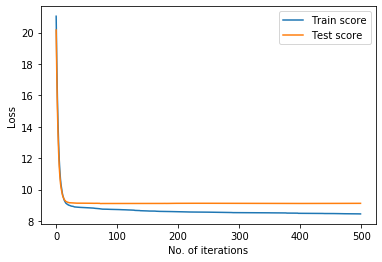

In [161]:
# plot training score and test score as a function of no. of estimators to study convergence
train = plt.plot(range(500), gbr3.train_score_, label="Train score")
test = plt.plot(range(500), test_score, label="Test score")
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [162]:
y_predicted_optimal = gbr3.predict(X_test)

In [163]:
y_predicted_optimal.shape

(2297,)

In [164]:
# calculate the optimal model performance
print('Gradient Boosting Regressor performance after hyper-parameter tuning is %0.4f' %mean_absolute_error(y_test, y_predicted_optimal))

Gradient Boosting Regressor performance after hyper-parameter tuning is 9.1213


In [176]:
# calculate mean of the absolute error as percentage of ground truth
np.mean(abs(y_test - y_predicted_optimal)/y_test)

0.3811411464899367

In [165]:
gbr3.feature_importances_

array([5.84149840e-02, 6.63279307e-01, 4.22457857e-02, 1.33271975e-02,
       3.67001072e-02, 7.50892017e-04, 9.07601177e-04, 6.72061794e-04,
       7.06620307e-04, 1.99509659e-04, 2.76958728e-04, 1.64786078e-01,
       1.32824145e-03, 1.64046562e-02])

In [166]:
# form a series object with feature_importances_ for easy sorting
feature_imp = pd.Series(data=gbr3.feature_importances_, index=feature_list)

In [167]:
# sort the feature importance
feature_imp1 = feature_imp.sort_values(ascending=False)

In [168]:
feature_imp1

Source EUI (kBtu/ft_)                          0.663279
Multifamily Housing                            0.164786
Site EUI (kBtu/ft_)                            0.058415
Total GHG Emissions (Metric Tons CO2e)_Norm    0.042246
Electricity Use - Grid Purchase (kBtu)_Norm    0.036700
Office                                         0.016405
Weather Norm Site Elect Int (kWh/ft_)          0.013327
Non-Refrigerated Warehouse                     0.001328
Brooklyn                                       0.000908
Bronx                                          0.000751
Queens                                         0.000707
Manhattan                                      0.000672
Hotel                                          0.000277
Staten Island                                  0.000200
dtype: float64

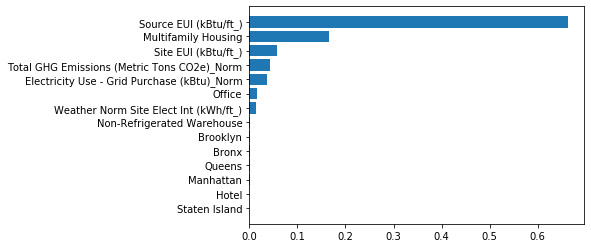

In [169]:
plt.barh(y=list(range(len(feature_imp),0,-1)), width=feature_imp1)
plt.yticks(ticks=list(range(len(feature_imp),0,-1)), labels=feature_imp1.index)
plt.show()